# Creating a "d13" model with adjustable complexity in the 2nd and the 3rd dimension

In [4]:
#all imports:
import numpy as np
import healpy as hp
import sympy as sym
import pysm3.units as u
import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 12, 16
plt.rcParams['font.family'] = 'sans-serif'  
import healpy as hp
import pysm3
import pysm3.units as u
from matplotlib.backends.backend_pdf import PdfPages
import sympy as sym
import scipy.constants as constants
import matplotlib
import pymaster as nmt
import funclib as lib

Create a model of the type

$$m_\nu = m^{d10}_{\nu_0} \times \text{MBB}_\nu(\bar{\beta}^{d9},\bar{T}^{d9})\times\left(\alpha_{2D}\mathcal{W}_\nu^{d10} +  \alpha_{3D}\mathcal{W}_\nu^{d12} \right) $$

where the maps $m_\nu$ are triplets
$$ m_\nu = \begin{bmatrix} I\\ Q \\ U\end{bmatrix}_\nu$$

# Compute and plot the moments to be added in the 2D and the 3D to a single constant mbb model

In [5]:
#general keywords
nside = 512
instr='Planck' # which instrument for the frequencies
fgtype='d10' #foreground model for 2D models
omax=3 #maximum order at which to compute the moments

if fgtype[0]=='d':
    model_type='mbb'
elif fgtype[0]=='s':
    model_type='PL'
npix =hp.nside2npix(nside)

#pick frequencies depending on instrument
if instr=='Planck':
    freq=np.array([100,143,217,353])
if instr=='LiteBIRD':
    freq=np.array([ 40.,  50.,  60.,  68.,  78.,  89., 100., 119., 140., 166., 195.,235., 280., 337., 402.])

N_freqs=len(freq)

#Get informations for the 2D moments
sky2D = pysm3.Sky(nside=nside, preset_strings=['%s'%fgtype])#,'s%s'%synctype])
dust2D = sky2D.components[0]
nu0=dust2D.freq_ref_P.value
betamap= np.array([dust2D.mbb_index.value])
tempmap= np.array([dust2D.mbb_temperature.value])
AI = np.array([dust2D.get_emission(nu0 * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0*u.GHz)).value])

#Get informations for the 3D moments from the d12 model
sky3D = pysm3.Sky(nside=nside, preset_strings=['d12'])#,'s%s'%synctype])
dust3D = sky3D.components[0]
betamap3D= dust3D.mbb_index.value
tempmap3D= dust3D.mbb_temperature.value
AI3D = dust3D.layers.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0*u.GHz)).value
    

In [6]:
#compute the moments for both 2D and 3D
mom, barbI, barbP, bartI, bartP = lib.compute_mom(nside,AI,betamap,tempmap,maxborder=omax,maxtorder=omax,SED_type=model_type,betabar=1.48,tempbar=19.6,pivot_type='2D')
mom3D, _, _, _, _ = lib.compute_mom(nside,AI3D,betamap3D,tempmap3D,maxborder=omax,maxtorder=omax,SED_type=model_type,pivot_type='3D')
mom3D = lib.crop_outliers(mom3D,maxborder=omax,maxtorder=omax,nsig=10) # remove outliers at 10 sigmas to avoid possible pathological values

pivot spectral index of expansion =1.48
pivot temperature of expansion =19.6
pivot spectral index of expansion =[1.66328744 1.64705301 1.70715502 ... 1.62370784 1.60111064 1.60964968]
pivot temperature of expansion =[16.19298768 15.77362481 15.51175071 ... 18.96438118 19.20883454
 19.51904412]


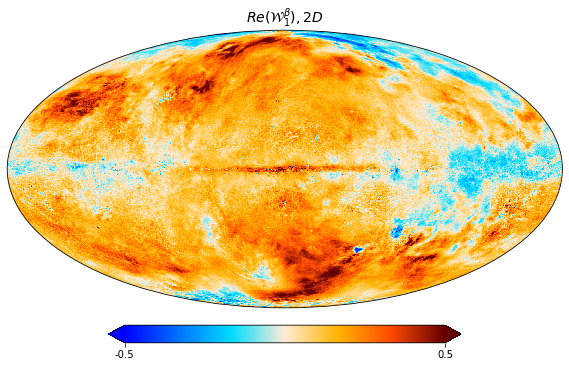

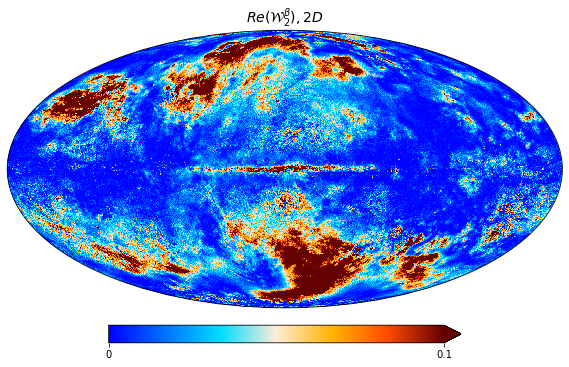

In [7]:
hp.projview(mom[1,1,0].real, cmap='planck', title=r'$Re(\mathcal{W}_1^\beta), 2D$',min=-0.5, max=0.5)
plt.show()

hp.projview(mom[1,2,0].real, cmap='planck', title=r'$Re(\mathcal{W}_2^\beta), 2D$',min=0, max=0.1)
plt.show()

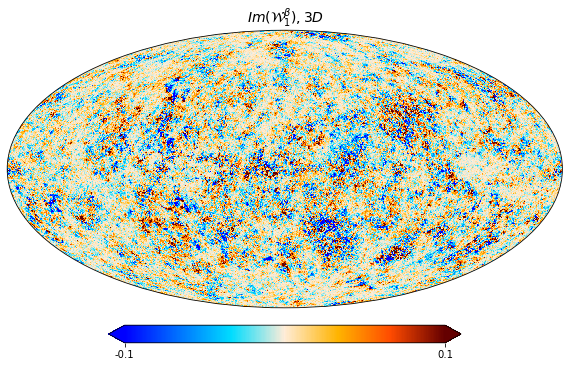

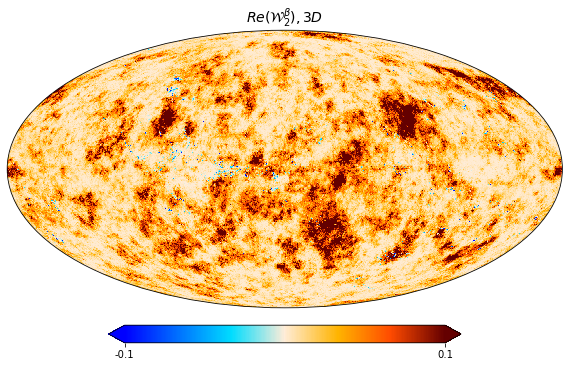

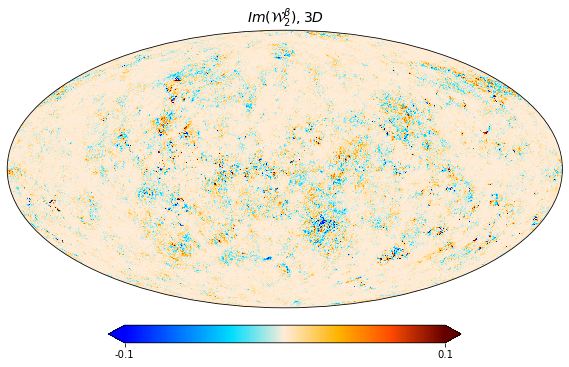

In [8]:
hp.projview(mom3D[1,1,0].imag, cmap='planck', title=r'$Im(\mathcal{W}_1^\beta), 3D$',min=-0.1, max=0.1)
plt.show()

hp.projview(mom3D[1,2,0].real, cmap='planck', title=r'$Re(\mathcal{W}_2^\beta), 3D$',min=-0.1, max=0.1)
plt.show()

hp.projview(mom3D[1,2,0].imag, cmap='planck', title=r'$Im(\mathcal{W}_2^\beta), 3D$',min=-0.1, max=0.1)
plt.show()

# Create the SED of the model with various values for $\alpha(2D)$ 

In [9]:
#build the SED of the model from the moment maps

# Get the canonical SED:
if model_type=='mbb':
    Abar=np.sum(AI,axis=0)
    barMBBI = lib.MBBpysm(freq,Abar[0],barbI,bartI,nu0)
    barMBBP = lib.MBBpysm(freq,Abar[1]+1j*Abar[2],barbP,bartP,nu0)
    barSED=np.array([barMBBI,barMBBP.real,barMBBP.imag])
elif model_type=='PL':
    Abar=np.sum(AI,axis=0)
    barPLI = lib.PLpysm(freq,Abar[0],barbI,nu0)
    barPLP = lib.PLpysm(freq,Abar[1]+1j*Abar[2],barbP,nu0)
    barSED=np.array([barPLI,barPLP.real,barPLP.imag])
    bartI=1
    bartP=1

#compute the maps for the expansion up to order omax:
modelmoms= np.zeros((5,N_freqs,3,npix))
alpha=[0,0.5,1,1.5,2] #different values for alpha(2D)
for a in range(len(alpha)):
    for idf in range(N_freqs):
        modelmoms[a,idf]= lib.model_SED_moments(nside,freq[idf], barSED[:,idf],mom,1/bartI,nu0=nu0,maxborder=omax,maxtorder=omax,tempmapP=1/bartP,mult_factor=alpha[a])
        

# Computing decorrelation for the various $\alpha (2D)$ values


In [10]:
mask = hp.read_map("./masks/mask_GAL070_512.fits")

b = nmt.bins.NmtBin(nside=nside,lmax=2*nside,nlb=10)
ell = b.get_effective_ells()

#compute decorrelation
F=3 #F=3 for the pair of frequencies 217x353
Delta = np.zeros((5,len(ell)-2))
for i in range(5):
    Delta[i] = lib.decorr(modelmoms[i,:,1:],F,mask,b,mode='BB')

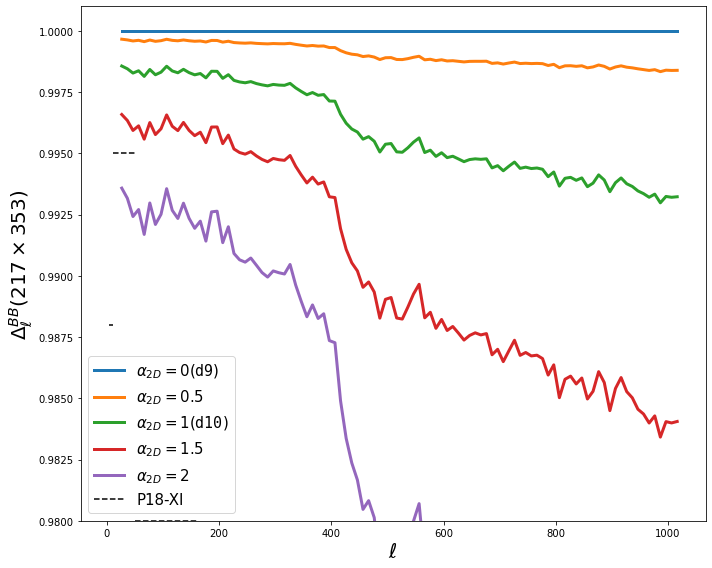

In [11]:
#Planck values for decorrelation on 70% of the sky (arxiv:1801.04945, Appendix B, Table B.1, mask "LR71")
DecPL = [0.988,0.995,0.980,0.926,0.786] #decorrelation
Lmin =[4,11,50,160,320,500] #ell ranges

label_alpha=[r"$\alpha_{2D}=0 ({\tt d9})$",r"$\alpha_{2D}=0.5$", r"$\alpha_{2D}=1 ({\tt d10})$", r"$\alpha_{2D}=1.5$", r"$\alpha_{2D}=2$"]
plt.figure(figsize=(10,8))
for i in range(len(alpha)):
    plt.plot(ell[2:],Delta[i],label=label_alpha[i],linewidth=3)
for i in range(len(DecPL)):
    if i==0:
         plt.plot((Lmin[i],Lmin[i+1]),(DecPL[i],DecPL[i]),c='k',linestyle='--',label='P18-XI')
    else:
        plt.plot((Lmin[i],Lmin[i+1]),(DecPL[i],DecPL[i]),c='k',linestyle='--')#,label='P18-XI')
plt.ylim([0.98,1.001])
plt.xlabel(r"$\ell$",fontsize=20)
plt.ylabel(r"$\Delta^{BB}_\ell(217\times353)$",fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()

# Create the SED of the model with various values for $\alpha(3D)$ 

In [12]:
#build the SED of the model from the moment maps

#compute the maps for the expansion up to order omax:
modelmoms_3D= np.zeros((5,N_freqs,3,npix))
alpha=[0,0.5,1,1.5,2] #different values for alpha(3D)
for a in range(len(alpha)):
    for idf in range(N_freqs):
        modelmoms_3D[a,idf]= lib.model_SED_moments(nside,freq[idf], barSED[:,idf],mom,1/bartI,nu0=nu0,maxborder=omax,maxtorder=omax,tempmapP=1/bartP,mult_factor=0, mom3D=mom3D, mult_factor_3D=alpha[a])
        

# Computing decorrelation for the various $\alpha (3D)$ values


In [13]:
F=3
Delta3D = np.zeros((5,len(ell)-2))
for i in range(5):
    Delta3D[i] = lib.decorr(modelmoms_3D[i,:,1:],F,mask,b,mode='BB')

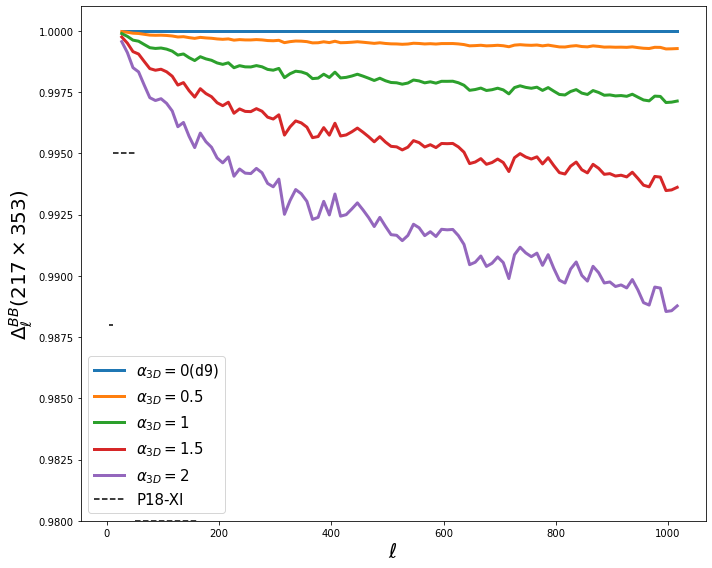

In [14]:
label_alpha=[r"$\alpha_{3D}=0 ({\tt d9})$",r"$\alpha_{3D}=0.5$", r"$\alpha_{3D}=1$", r"$\alpha_{3D}=1.5$", r"$\alpha_{3D}=2$"]
plt.figure(figsize=(10,8))
for i in range(len(alpha)):
    plt.plot(ell[2:],Delta3D[i],label=label_alpha[i],linewidth=3)
for i in range(len(DecPL)):
    if i==0:
         plt.plot((Lmin[i],Lmin[i+1]),(DecPL[i],DecPL[i]),c='k',linestyle='--',label='P18-XI')
    else:
        plt.plot((Lmin[i],Lmin[i+1]),(DecPL[i],DecPL[i]),c='k',linestyle='--')#,label='P18-XI')
plt.ylim([0.98,1.001])
plt.xlabel(r"$\ell$",fontsize=20)
plt.ylabel(r"$\Delta^{BB}_\ell(217\times353)$",fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()